## OR-ResNet-18 Classification Demo

Download the [model definition](https://gist.github.com/ZhouYanzhao/c7f75cd8ea3c92e2044d71ac7bc30fab/raw/or-resnet.lua), the [pre-trained weights](https://1drv.ms/u/s!Avhhrlo9ASwciWcEjJ_KWBgTWWyg) and the [ImageNet-labels](https://gist.github.com/ZhouYanzhao/c7f75cd8ea3c92e2044d71ac7bc30fab/raw/imagenet_labels.lua)

In [1]:
require 'orn'
require 'image'
labels = require './imagenet_labels'

In [2]:
-- Init pre-trained OR-ResNet-18 model
model = require('or-resnet')({tensorType='torch.CudaTensor', pretrained='or-resnet18_weights.t7'})
model:add(cudnn.SoftMax():cuda())
model:evaluate()
print(model:__tostring())

 | OR-ResNet-18 ImageNet	


nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> output]
  (1): cudnn.SpatialConvolution(3 -> 64, 3x3, 1,1, 1,1) without bias
  (2): cudnn.SpatialBatchNormalization
  (3): cudnn.ReLU
  (4): cudnn.SpatialConvolution(64 -> 64, 3x3, 2,2, 1,1) without bias
  (5): cudnn.SpatialBatchNormalization
  (6): cudnn.ReLU
  (7): nn.SpatialMaxPooling(3x3, 2,2, 1,1)
  (8): nn.Sequential {
    [input -> (1) -> (2) -> output]
    (1): nn.Sequential {
      [input -> (1) -> (2) -> (3) -> output]
      (1): nn.ConcatTable {
        input
          |`-> (1): nn.Sequential {
          |      [input -> (1) -> (2) -> (3) -> (4) -> (5) -> output]
          |      (1): cudnn.ORConv([1-4] 64 -> 32, 3x3, 1,1, 1,1) without bias, fast mode
          |      (2): cudnn.SpatialBatchNormalization
          |      (3): cudnn.ReLU
          |      (4): cudnn.ORConv([4] 32 -> 32, 3x3, 1,1, 1,1) without bias, fast mode
       

 |      (3): cudnn.ReLU
          |      (4): cudnn.ORConv([4] 128 -> 128, 3x3, 1,1, 1,1) without bias, fast mode
          |      (5): cudnn.SpatialBatchNormalization
          |    }
           `-> (2): nn.Sequential {
                 [input -> (1) -> (2) -> output]
                 (1): cudnn.ORConv([4] 64 -> 128, 1x1, 2,2) without bias, fast mode
                 (2): cudnn.SpatialBatchNormalization
               }
           ... -> output
      }
      (2): nn.CAddTable
      (3): cudnn.ReLU
    }
    (2): nn.Sequential {
      [input -> (1) -> (2) -> (3) -> output]
      (1): nn.ConcatTable {
        input
          |`-> (1): nn.Sequential {
          |      [input -> (1) -> (2) -> (3) -> (4) -> (5) -> output]
          |      (1): cudnn.ORConv([4] 128 -> 128, 3x3, 1,1, 1,1) without bias, fast mode
          |      (2): cudnn.SpatialBatchNormalization
          |      (3): cudnn.ReLU
          |      (4): cudnn.ORConv([4] 128 -> 128, 3x3, 1,1, 1,1) without bias, fast mode
     

In [3]:
-- Image transforms
M = {}

function M.Compose(transforms)
   return function(input)
      for _, transform in ipairs(transforms) do
         input = transform(input)
      end
      return input
   end
end

function M.ColorNormalize(meanstd)
   return function(img)
      img = img:clone()
      for i=1,3 do
         img[i]:add(-meanstd.mean[i])
         img[i]:div(meanstd.std[i])
      end
      return img
   end
end

-- Scales the smaller edge to size
function M.Scale(size, interpolation)
   interpolation = interpolation or 'bicubic'
   return function(input)
      local w, h = input:size(3), input:size(2)
      if (w <= h and w == size) or (h <= w and h == size) then
         return input
      end
      if w < h then
         return image.scale(input, size, h/w * size, interpolation)
      else
         return image.scale(input, w/h * size, size, interpolation)
      end
   end
end

-- Crop to centered rectangle
function M.CenterCrop(size)
   return function(input)
      local w1 = math.ceil((input:size(3) - size)/2)
      local h1 = math.ceil((input:size(2) - size)/2)
      return image.crop(input, w1, h1, w1 + size, h1 + size) -- center patch
   end
end

In [4]:
-- Image pre-processing
meanstd = {
   mean = { 0.485, 0.456, 0.406 },
   std = { 0.229, 0.224, 0.225 },
}
preprocess = M.Compose{
     M.Scale(256),
     M.ColorNormalize(meanstd),
     M.CenterCrop(224),
  }

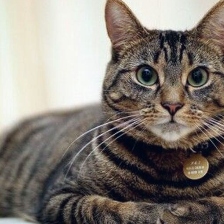

In [5]:
-- Load an image
img = preprocess(image.load('Cat.jpg', 3, 'float'))
itorch.image(img)

In [6]:
-- Forwarding
batch = img:view(1, table.unpack(img:size():totable()))
output = model:forward(batch:cuda()):squeeze()

In [7]:
-- Top5 predictions
N = 5
probs, indexes = output:topk(N, true, true)
for n=1, N do
     print(probs[n], labels[indexes[n]])
end

0.62781953811646	tabby, tabby cat	
0.18881273269653	Egyptian cat	


0.16771727800369	tiger cat	
0.0011343017686158	tiger, Panthera tigris	
0.0010373247787356	carton	
